# Data-based Systems Results analysis

In this notebook we are going to analyze the runs of the best data-based system ([d] configuration). Our best system is obtained with the Stream Parsing configuration (Jena + LightRDF) with triple deduplication and by using the Lucene Tokenizer and the NLTK Stoplist. In order to see what we are missing with respect to the data-based system developed by ACORDAR we are going to analyze the following aspects:
- Impact of empty datasets
- Impact of partial datasets

All the analysis will be conduced by using the the run files and score files geenrated by using the <code>generate_scores.py</code> script. 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

dirname = os.path.dirname(__name__)

## 1. Impact of Empty Datasets

Since during the download and parsing phases we are losing some files because of download and parsing errors, now we are going to consider the impact of the empty datasets (datasets without a parsed file). 

In [17]:
#open the empty datasets list

empty_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/stream/empty_datasets_stream.json"), "r")
empty_datasets = json.load(empty_datasets_file)
empty_datasets_file.close()
empty_datasets = set(empty_datasets)

In [18]:
# get a map query id -> empty relevant datasets

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"))

empty_relevant_datasets_per_query = dict()

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if dataset_id in empty_datasets and rel > 0:
        if query_id not in empty_relevant_datasets_per_query.keys():
            empty_relevant_datasets_per_query[query_id] = set()

        empty_relevant_datasets_per_query[query_id].add(dataset_id)

print(len(empty_relevant_datasets_per_query.keys()))

232


In [19]:
def getInfo(run_file):
    
    empty_datasets_per_query = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])

        if query_id in empty_relevant_datasets_per_query.keys() and dataset_id in empty_relevant_datasets_per_query[query_id]:
            if query_id not in empty_datasets_per_query.keys():
                empty_datasets_per_query[query_id] = list()

            empty_datasets_per_query[query_id].append(dataset_id)

    affected_queries = len(empty_datasets_per_query.keys())

    buckets = dict()
    sum = 0
    for query in empty_datasets_per_query.keys():
        n_empty_datasets = len(empty_datasets_per_query[query])
        sum += n_empty_datasets
        
        if n_empty_datasets not in buckets.keys():
            buckets[n_empty_datasets] = 0

        buckets[n_empty_datasets] += 1

    return affected_queries, buckets,  sum / len(empty_datasets_per_query.keys())


In [20]:
def showInfoAndHistogram(run_file, run_name):
    info = getInfo(run_file)
    buckets = list(info[1].keys())
    values = list(info[1].values())
    print(f"{run_name}: {info[0]} {info[2]}")
    plt.bar(buckets, values, color='g')
    plt.title(f"{run_name}")
    plt.xlabel("Number of empty datasets")
    plt.ylabel("Number of queries")

    # Add value labels on top of each bar
    for i in range(len(values)): 
        plt.text(buckets[i], values[i] , str(values[i]), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()

BM25: 59 1.4745762711864407


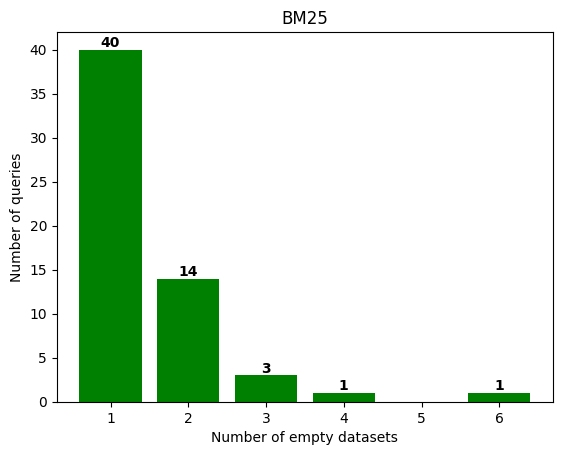

TFIDF: 67 1.3582089552238805


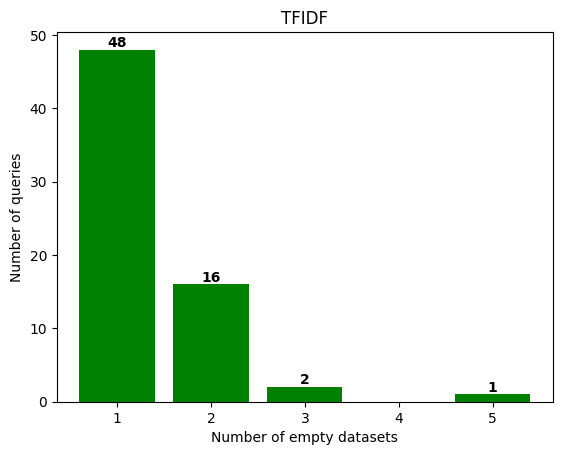

LMD: 76 1.381578947368421


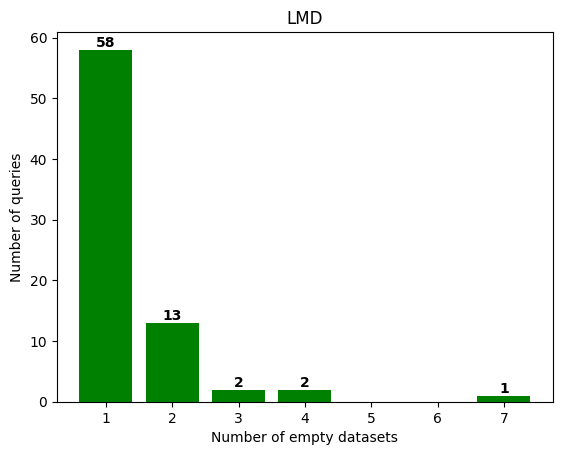

FSDM: 75 1.4666666666666666


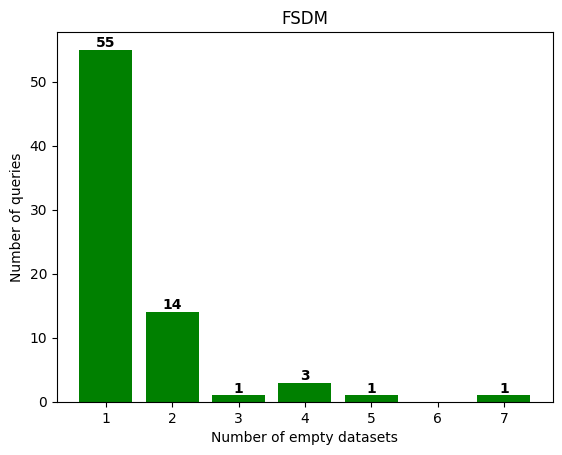

In [21]:
#open the run files for every similarity in ACORDAR
acordar_bm25_run = open(os.path.join(dirname, "../../files/run/ACORDAR/BM25[d].txt"))
acordar_tfidf_run = open(os.path.join(dirname, "../../files/run/ACORDAR/TF-IDF[d].txt"))
acordar_lmd_run = open(os.path.join(dirname, "../../files/run/ACORDAR/LMD[d].txt"))
acordar_fsdm_run = open(os.path.join(dirname, "../../files/run/ACORDAR/FSDM[d].txt"))
 
#open the run files for every similarity in ARDFS
ardfs_bm25_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/BM25Boost[d].txt"))
ardfs_tfidf_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/TFIDFBoost[d].txt"))
ardfs_lmd_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/LMDBoost[d].txt"))
ardfs_fsdm_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/FSDM[d].txt"))

showInfoAndHistogram(acordar_bm25_run, "BM25")
showInfoAndHistogram(acordar_tfidf_run, "TFIDF")
showInfoAndHistogram(acordar_lmd_run, "LMD")
showInfoAndHistogram(acordar_fsdm_run, "FSDM")

## 2.0 Impact of Partial Datasets

Since during the download and parsing phases we are losing some files because of download and parsing errors, now we are going to consider the impact of the partial datasets (datasets without at least one parsed file). 

In [22]:
#load the more fine grained stats about partial datasets
fine_grained_partial_list_json = open(os.path.join(dirname, "../../files/datasets_lists/stream/partial_datasets_stream_fine.json"), "r")
fine_grained_partial_map = json.load(fine_grained_partial_list_json)
partial_datasets = set()
for partial_dataset in fine_grained_partial_map.keys():
    if fine_grained_partial_map[partial_dataset] < 0.5:
        partial_datasets.add(int(partial_dataset))   

print(len(partial_datasets))     

41


In [23]:
# get a map query id -> partial relevant datasets

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"))

partial_relevant_datasets_per_query = dict()

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if dataset_id in partial_datasets and rel > 0:
        if query_id not in partial_relevant_datasets_per_query.keys():
            partial_relevant_datasets_per_query[query_id] = set()

        partial_relevant_datasets_per_query[query_id].add(dataset_id)

print(len(partial_relevant_datasets_per_query.keys()))
print(partial_relevant_datasets_per_query)

26
{1148: {15381}, 1026: {14603, 13357}, 1091: {13283, 14277}, 1094: {13283, 14277}, 102: {13574}, 134: {14277}, 204: {13356}, 1023: {13283, 14277}, 1175: {14011}, 248: {13284}, 1112: {13796, 14806}, 180: {14417, 13284}, 181: {14417, 13284}, 1096: {14417, 13284}, 1018: {13283, 14277}, 1021: {14603, 13357}, 1093: {14603, 13357}, 105: {15381}, 61: {14417}, 203: {14011}, 67: {13574}, 63: {14417, 13284}, 60: {13284}, 1051: {13283, 14277}, 1241: {14603, 13357}, 1117: {14011}}


In [24]:
#check if the partial relevant datasets are returned by the ARDFS runs

def generateRank(run_file):
    rank = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])

        if query_id not in rank:
            rank[query_id] = list()

        rank[query_id].append(dataset_id)
    
    return rank


In [25]:
def generateDiffPartialDatasets(acordar_ranks, ardfs_ranks):
    difference = 0
    max_diff = 0 
    min_diff = 10
    for query in partial_relevant_datasets_per_query.keys():
        partial_relevant_datasets_in_query = partial_relevant_datasets_per_query[query]

        for dataset in partial_relevant_datasets_in_query:
            pos_acordar = 11
            if dataset in acordar_ranks[query]:
                pos_acordar = acordar_ranks[query].index(dataset) + 1 
            
            pos_ardfs = 11
            if dataset in ardfs_ranks[query]:
                pos_ardfs = ardfs_ranks[query].index(dataset) + 1
            
            local_diff = - (pos_acordar - pos_ardfs )

            difference += local_diff

            if local_diff < min_diff:
                min_diff = local_diff
            if local_diff > max_diff:
                max_diff = local_diff
    
    return min_diff, max_diff,  difference / len(partial_relevant_datasets_per_query.keys())



In [26]:
#open the run files for every similarity in ACORDAR
acordar_bm25_run = open(os.path.join(dirname, "../../files/run/ACORDAR/BM25[d].txt"))
acordar_tfidf_run = open(os.path.join(dirname, "../../files/run/ACORDAR/TF-IDF[d].txt"))
acordar_lmd_run = open(os.path.join(dirname, "../../files/run/ACORDAR/LMD[d].txt"))
acordar_fsdm_run = open(os.path.join(dirname, "../../files/run/ACORDAR/FSDM[d].txt"))
 
#open the run files for every similarity in ARDFS
ardfs_bm25_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/BM25Boost[d].txt"))
ardfs_tfidf_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/TFIDFBoost[d].txt"))
ardfs_lmd_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/LMDBoost[d].txt"))
ardfs_fsdm_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/FSDM[d].txt"))

acordar_bm25_ranks = generateRank(acordar_bm25_run)
acordar_tfidf_ranks = generateRank(acordar_tfidf_run)
acordar_lmd_ranks = generateRank(acordar_lmd_run)
acordar_fsdm_ranks = generateRank(acordar_fsdm_run)

ardfs_bm25_ranks = generateRank(ardfs_bm25_run)
ardfs_tfidf_ranks = generateRank(ardfs_tfidf_run)
ardfs_lmd_ranks = generateRank(ardfs_lmd_run)
ardfs_fsdm_ranks = generateRank(ardfs_fsdm_run)

print(f"BM25: f{generateDiffPartialDatasets(acordar_bm25_ranks, ardfs_bm25_ranks)}")
print(f"TFIDF: {generateDiffPartialDatasets(acordar_tfidf_ranks, ardfs_tfidf_ranks)}")
print(f"LMD:  {generateDiffPartialDatasets(acordar_lmd_ranks, ardfs_lmd_ranks)}")
print(f"FSDM: {generateDiffPartialDatasets(acordar_fsdm_ranks, ardfs_fsdm_ranks)}")

BM25: f(-3, 10, 2.0)
TFIDF: (-1, 10, 2.230769230769231)
LMD:  (-6, 10, 1.6923076923076923)
FSDM: (-8, 10, 1.6153846153846154)


## Output Scores

Let's analyze the differences in the output scores of the common datasets between the ACORDAR and ARDFS runs

In [27]:
def generate_ranks_with_scores(run_file):
    ranks = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])
        score = float(split[4])

        if query_id not in ranks.keys():
            ranks[query_id] = dict()

        ranks[query_id][dataset_id] = score
    
    return ranks

In [28]:
def getAverageScoreDifference(acordar_ranks, ardfs_ranks):
    abs_diff = 0
    n = 0 
    for query in acordar_ranks.keys():
        acordar_rank = set(acordar_ranks[query].keys())
        ardfs_rank = set(ardfs_ranks[query].keys())

        #common datasets 
        common_datasets = acordar_rank.intersection(ardfs_rank)

        #absolute difference
        for dataset in common_datasets:
            
            abs_diff += abs(acordar_ranks[query][dataset] - ardfs_ranks[query][dataset])
        
        n += len(common_datasets)

    return abs_diff/n

In [29]:
#load my ranks and acordar ones for all the queries in order to see a diff



#open the run files for every similarity in ACORDAR
acordar_bm25_run = open(os.path.join(dirname, "../../files/run/ACORDAR/BM25[d].txt"))
acordar_tfidf_run = open(os.path.join(dirname, "../../files/run/ACORDAR/TF-IDF[d].txt"))
acordar_lmd_run = open(os.path.join(dirname, "../../files/run/ACORDAR/LMD[d].txt"))
acordar_fsdm_run = open(os.path.join(dirname, "../../files/run/ACORDAR/FSDM[d].txt"))
 
#open the run files for every similarity in ARDFS
ardfs_bm25_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/BM25Boost[d].txt"))
ardfs_tfidf_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/TFIDFBoost[d].txt"))
ardfs_lmd_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/LMDBoost[d].txt"))
ardfs_fsdm_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Deduplication/FSDM[d].txt"))

acordar_bm25_ranks_with_score = generate_ranks_with_scores(acordar_bm25_run)
acordar_tfidf_ranks_with_score = generate_ranks_with_scores(acordar_tfidf_run)
acordar_lmd_ranks_with_score = generate_ranks_with_scores(acordar_lmd_run)
acordar_fsdm_ranks_with_score = generate_ranks_with_scores(acordar_fsdm_run)

ardfs_bm25_ranks_with_score = generate_ranks_with_scores(ardfs_bm25_run)
ardfs_tfidf_ranks_with_score = generate_ranks_with_scores(ardfs_tfidf_run)
ardfs_lmd_ranks_with_score = generate_ranks_with_scores(ardfs_lmd_run)
ardfs_fsdm_ranks_with_score = generate_ranks_with_scores(ardfs_fsdm_run)



In [30]:

print(f"Average BM25: {getAverageScoreDifference(acordar_bm25_ranks_with_score, ardfs_bm25_ranks_with_score)}")
print(f"Average TFIDF: {getAverageScoreDifference(acordar_tfidf_ranks_with_score, ardfs_tfidf_ranks_with_score)}")
print(f"Average LMD: {getAverageScoreDifference(acordar_lmd_ranks_with_score, ardfs_lmd_ranks_with_score)}")
print(f"Average FSDM: {getAverageScoreDifference(acordar_fsdm_ranks_with_score, ardfs_fsdm_ranks_with_score)}")

Average BM25: 0.9695013690265606
Average TFIDF: 0.25893791806831173
Average LMD: 2.3749827949766518
Average FSDM: 3.1617209719217922
